# Build a model to classify topics for Telegram channels

**Pre-req**
1. Download csv from gdrive with channels and save to ``data/external/telegram_channels.csv``
2. Run ``python -m src.train.download`` to get posts and meta-data

**Steps**
1. Load data:
    - posts from channels
    - channel titles and descriptions
    - channel topics
2. Build a training dataset:
    1. Merge
    2. Select inputs
    3. Split into train/val
3. Build models:
    1. Embed text
    2. Train a classifier
    3. Select best
4. Evaluate on test data and save best

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#standard libs
import os, sys
from pathlib import Path
from pprint import pprint
from collections import Counter
import random
import json
import itertools
from datetime import datetime as dt

# ds libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm, notebook_tqdm

from torchtext import data
import re


/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# custom path
os.chdir('..')
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [3]:
VOCAB = "./notebooks/vocabulary.txt"
SPE_TOKENIZER = "./models/trained/tglang_spe_unigram_10000.model"

USE_SPE = False
WITH_VOCAB = False
USE_ONMT = True
ONMT_MODE = "conservative"

TRAIN_DATA = "./data/processed/tglang_train.csv"
TEST_DATA = "./data/processed/tglang_test.csv"

## Text prep

In [4]:
from collections import Counter

### Load data

In [5]:
thestack = pd.read_csv(TRAIN_DATA)
thestack = thestack.loc[~thestack["content"].isna()]
thestack["content"] = thestack["content"].astype(str)
thestack["lang"] = thestack["lang"].astype(str)

thestack.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33203 entries, 0 to 33204
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    33203 non-null  object
 1   lang       33203 non-null  object
 2   num_chars  33203 non-null  int64 
 3   num_lines  33203 non-null  int64 
 4   file       33203 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.5+ MB


In [6]:
test_set = pd.read_csv(TEST_DATA)
test_set = test_set.loc[~test_set["content"].isna()]
test_set["content"] = test_set["content"].astype(str)
test_set["lang"] = test_set["lang"].astype(str)

test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2262 entries, 0 to 2261
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    2262 non-null   object
 1   lang       2262 non-null   object
 2   num_chars  2262 non-null   int64 
 3   num_lines  2262 non-null   int64 
 4   file       2262 non-null   object
dtypes: int64(2), object(3)
memory usage: 106.0+ KB


### Load vocab

In [7]:

vocab = Path(VOCAB).read_text().split("\n")

print("Vocab size:", len(vocab))

pprint(random.choices(vocab, k=10))

Vocab size: 1461
['storage',
 'union',
 'bytes',
 'precompile',
 'dec',
 'nmtoken',
 'abbr',
 'resb',
 'equals',
 'rd']


### Tokenizer

In [8]:
import functools
import torch
import pyonmttok

In [9]:
from torchtext.transforms import SentencePieceTokenizer

transform_sentpiece = SentencePieceTokenizer(SPE_TOKENIZER)

spe_scripted = torch.jit.script(transform_sentpiece)

In [16]:
%%time

onmt_tokenizer = pyonmttok.Tokenizer(mode=ONMT_MODE, case_feature=False)

CPU times: user 28 µs, sys: 136 µs, total: 164 µs
Wall time: 1.12 ms


In [17]:
def check_vocab(x):
    if x in VOCAB:
        return True
    else:
        return False
    
    
def split_text(x, with_vocab=WITH_VOCAB):
    x = x.lower()
    tokens = re.split("[\W']+", x)
    tokens = list(filter(bool, tokens))
    
    if with_vocab:
        tokens = list(filter(check_vocab, tokens))
    return tokens


def tokenize_onmt(text):
    return onmt_tokenizer.tokenize(text)[0]


if USE_ONMT:
    tokenize_text = tokenize_onmt
elif USE_SPE:
    tokenize_text = spe_scripted
else:
    tokenize_text = functools.partial(split_text, with_vocab=WITH_VOCAB)

In [18]:
smp = thestack.sample(2)

for _, row in smp.iterrows():
    tokens = tokenize_text(row["content"])
    print(f"================== {row['lang']} =================", end="\n\n")
    print(row["content"], end="\n\n")
    print("TOKENS:", Counter(tokens), sep="\n", end="\n\n")

================== TGLANG_LANGUAGE_DART =================

          ],
        ),
        child: ne

TOKENS:
Counter({',': 2, ']': 1, ')': 1, 'child': 1, ':': 1, 'ne': 1})

================== TGLANG_LANGUAGE_JAVA =================

    }
    public void setConfigurer(Consumer<RouteTemplateContext> configurer) {
        this.configurer = configurer;
    }
    public Consumer<RouteTemplateContext> getConfigurer() {
        return configurer;
    }
    // Fluent API
    // -------------------------------------------------------------------------
    /**

TOKENS:
Counter({'-': 73, '/': 5, '}': 3, 'configurer': 3, 'public': 2, '(': 2, 'Consumer': 2, '<': 2, 'RouteTemplateContext': 2, '>': 2, ')': 2, '{': 2, ';': 2, '*': 2, 'void': 1, 'setConfigurer': 1, 'this.configurer': 1, '=': 1, 'getConfigurer': 1, 'return': 1, 'Fluent': 1, 'API': 1})



## Experiments

**Hyper-parameters:**
- [x] topics: primary only, primary + secondary
- [x] inputs: title, description, posts
- [x] preprocessing: raw, lemmas
- [x] vectorizers: tf-idf, bow
- [x] clf: xgb, nb, etc.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import ComplementNB, MultinomialNB

# from xgboost import XGBClassifier

import itertools

In [20]:
class Trainer:
    """ prapre inputs, vectorize texts and run a classifier """
    def __init__(self, input_fields, preprocessing, vect, est):
        self.INPUT_FIELDS = input_fields
        self.vect = VECTORIZERS[vect]
        self.vect.preprocessor = lambda x: x
        self.vect.lowercase = False
        self.clf = ESTIMATORS[est]
        assert preprocessing in ['raw']
        self.preprocessing = preprocessing
        
    def prepare_data(self, is_final):
        # combine fields
        data = thestack.copy()
        data["text"] = thestack.apply(lambda x: " ".join([x[f] for f in self.INPUT_FIELDS]),
                                      axis=1)
        # split into  train and test
        one, self.test_inputs = train_test_split(data, test_size=0.2, random_state=24, shuffle=True,)
        comb_datasets = [one, self.test_inputs] if is_final else [one]
        self.train_inputs = pd.concat(comb_datasets, axis=0)
        # x and y
        self.y_train = self.train_inputs['lang']
        self.y_test = self.test_inputs['lang']
        self.X_train = self.vect.fit_transform(self.train_inputs['text'])
        self.X_test = self.vect.transform(self.test_inputs['text'])
        
        
    def run_eval(self, final=False):
        """ prepare inputs and run clf evaluation """
        self.prepare_data(final)
        # fit and eval
        self.clf.fit(self.X_train, self.y_train)
        self.predictions = pd.DataFrame({
                    'true': trainer.test_inputs['lang'],
                    'predicted': trainer.clf.predict(trainer.X_test)
                })
        score = self.predictions.apply(lambda x: x['predicted'] == x['true'], axis=1).mean()
        return score
    
    def predict(self, inputs):
        tokens = self.vect.transform(inputs)
        return self.clf.predict(tokens)
        
    @staticmethod
    def score(predictions, gt):
        return (predictions == gt).mean()

### Set hyper-parameters

In [50]:
INPUTS = [
    'content',
#     "punct",
]

PREPROCESSING = [
    'raw',
]

vect_params = dict(
    max_df=0.25, 
    min_df=3,
    max_features=1000,
    binary=False, 
    ngram_range=(1,1), 
    stop_words=None,
#     tokenizer= lambda x: re.split(),
    tokenizer=tokenize_text,
    
)
VECTORIZERS = {
    'tfidf': TfidfVectorizer(**vect_params),
    'bow': CountVectorizer(**vect_params),
}


ESTIMATORS = dict(
#     xgb = XGBClassifier(objective='multi:softmax'),
#     forest = RandomForestClassifier(),
#     logreg = LogisticRegression(),
#     knn = KNeighborsClassifier(),
#     tree = ExtraTreeClassifier(),
#     svm = SVC(),
#     linsvm = LinearSVC(),
    cnb = ComplementNB(),
    mnb = MultinomialNB(),
)

In [51]:
input_combinations = [INPUTS] #list(itertools.combinations(INPUTS, r=2)) + [INPUTS]

train_params = list(itertools.product( 
                                input_combinations,
                                      PREPROCESSING,
                                VECTORIZERS.keys(), 
                                ESTIMATORS.keys()))

len(train_params)

4

### Run experiments

In [52]:
X_test = test_set["content"]
y_test = test_set["lang"]


In [53]:
results = []

for params in notebook_tqdm(train_params, desc='# experiments'):
    trainer = Trainer(*params)
    val_score = trainer.run_eval()
    test_score = trainer.score(trainer.predict(X_test), y_test)
    score = (val_score + test_score * 2) / 3
    params += (val_score, test_score, score)
    results.append(params)
                
results = pd.DataFrame(results, columns=['input_fields', 'preprocessing','vect', 'est', 
                                         'val_score', "test_score", "score"])

# experiments:   0%|                                                                                                                                                             | 0/4 [00:00<?, ?it/s]/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
# experiments:  25%|█████████████████████████████████████▎                                                                                                               | 1/4 [00:01<00:03,  1.05s/it]/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
# experiments:  50%|██████████████████████████████████████████████████████████████████████████▌                                               

In [54]:
print(results.sort_values('score', ascending=False).to_markdown())

|    | input_fields   | preprocessing   | vect   | est   |   val_score |   test_score |    score |
|---:|:---------------|:----------------|:-------|:------|------------:|-------------:|---------:|
|  1 | ['content']    | raw             | tfidf  | mnb   |    0.72459  |     0.740495 | 0.735193 |
|  3 | ['content']    | raw             | bow    | mnb   |    0.727601 |     0.681698 | 0.696999 |
|  0 | ['content']    | raw             | tfidf  | cnb   |    0.612408 |     0.543324 | 0.566352 |
|  2 | ['content']    | raw             | bow    | cnb   |    0.585002 |     0.509284 | 0.534523 |


### Review errors

In [55]:
from sklearn.metrics import top_k_accuracy_score

#### Train

In [56]:
best_params = results.sort_values("score", ascending=False).iloc[0].to_dict()
best_params.pop("score"), best_params.pop("val_score"), best_params.pop("test_score")

(0.7351933147747031, 0.724589670230387, 0.7404951370468612)

In [57]:
trainer = Trainer(**best_params)
s = trainer.run_eval(final=False)
print(s)

/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.724589670230387


#### Classification report

In [58]:
from sklearn.metrics import classification_report

In [59]:

test_pred = trainer.predict(X_test)

is_wrong = test_pred != y_test

errors = test_set.loc[is_wrong]

errors['predicted'] = test_pred[is_wrong]

/var/folders/fg/vxz9bx5n1vvb2p8k4cr_wc9h0000gp/T/ipykernel_69269/2620725147.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors['predicted'] = test_pred[is_wrong]


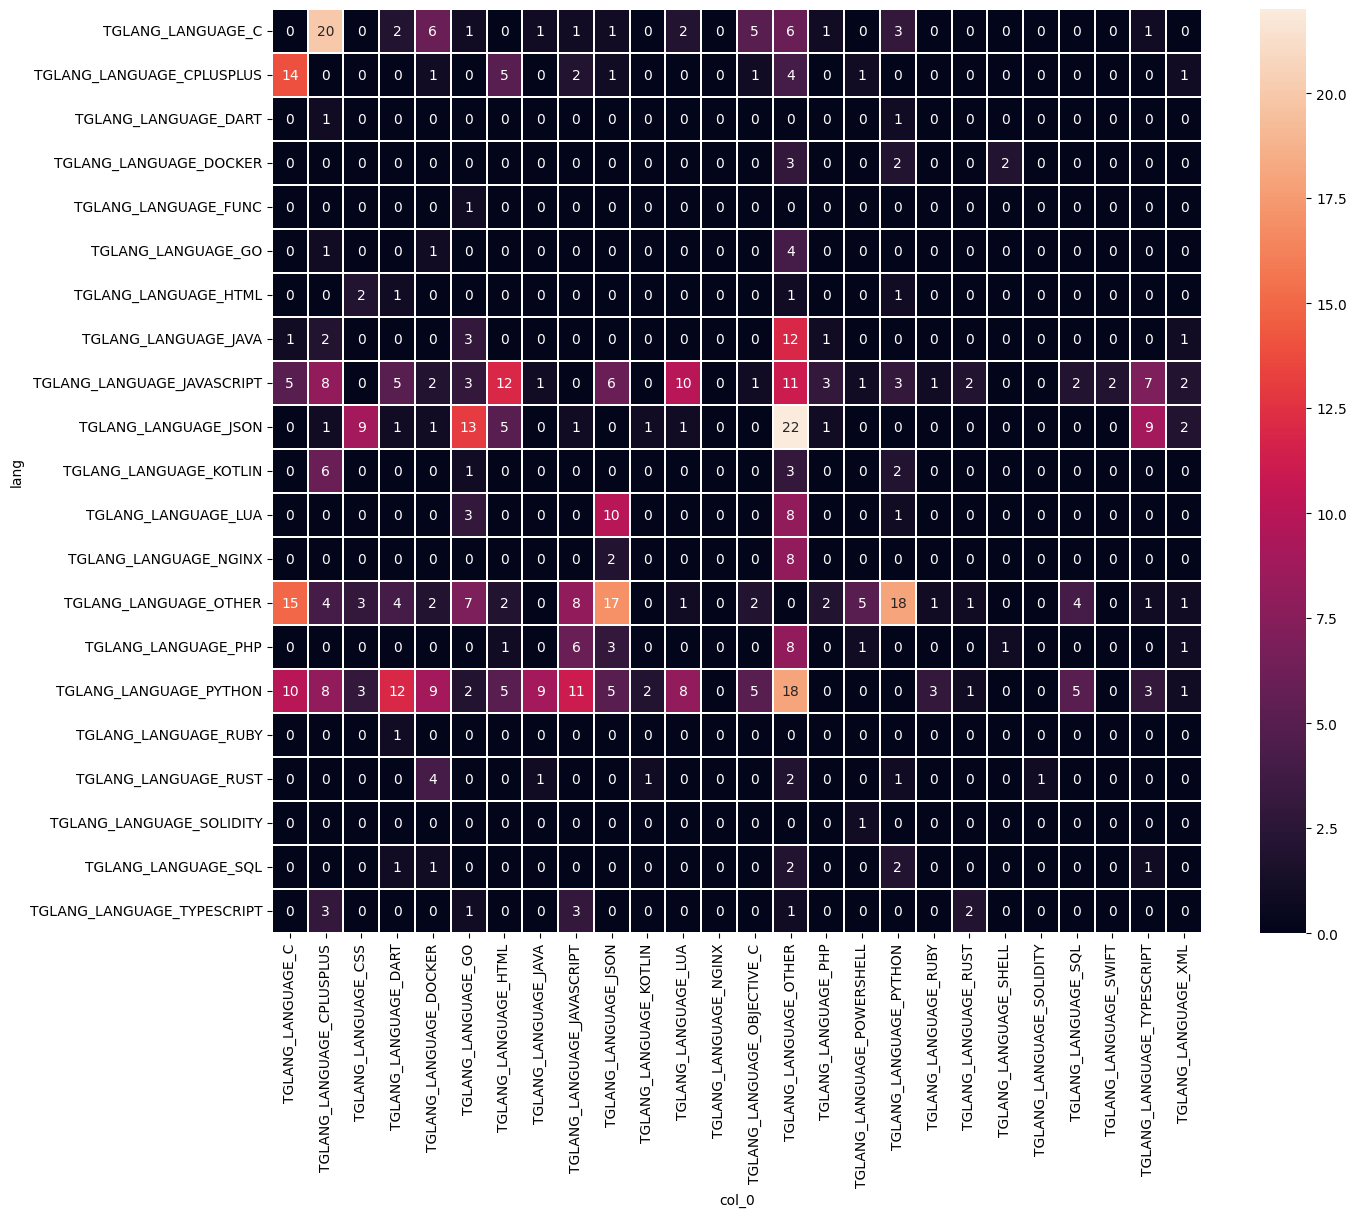

In [60]:
ct = pd.crosstab(y_test, test_pred)
for i,k in ct.iterrows():
    k[i] = 0


plt.figure(figsize=(15,12))
sns.heatmap(ct, annot=True, linewidths=0.01);

In [61]:
metrics = pd.DataFrame(classification_report(y_test, test_pred, output_dict=True, zero_division=0)).T

metrics = metrics.query("support > 0").sort_values('f1-score', ascending=True)

print(metrics.to_markdown())

|                            |   precision |   recall |   f1-score |     support |
|:---------------------------|------------:|---------:|-----------:|------------:|
| TGLANG_LANGUAGE_FUNC       |   0         | 0        |   0        |    1        |
| TGLANG_LANGUAGE_DART       |   0.0689655 | 0.5      |   0.121212 |    4        |
| TGLANG_LANGUAGE_DOCKER     |   0.15625   | 0.416667 |   0.227273 |   12        |
| TGLANG_LANGUAGE_C          |   0.237288  | 0.21875  |   0.227642 |   64        |
| TGLANG_LANGUAGE_RUBY       |   0.166667  | 0.5      |   0.25     |    2        |
| TGLANG_LANGUAGE_TYPESCRIPT |   0.241379  | 0.411765 |   0.304348 |   17        |
| TGLANG_LANGUAGE_LUA        |   0.3125    | 0.3125   |   0.3125   |   32        |
| macro avg                  |   0.38987   | 0.408092 |   0.375165 | 2262        |
| TGLANG_LANGUAGE_JAVA       |   0.478261  | 0.354839 |   0.407407 |   31        |
| TGLANG_LANGUAGE_JAVASCRIPT |   0.573333  | 0.330769 |   0.419512 |  130        |
| TG

#### Errors

In [62]:
TRUE_CLASS = "TGLANG_LANGUAGE_PYTHON"
PRED_CLASS = None  # "TGLANG_LANGUAGE_C"

class_errors = test_set.loc[(y_test == TRUE_CLASS) & 
                                   ((test_pred == PRED_CLASS ) if PRED_CLASS else (test_pred != TRUE_CLASS))
                                  ]

for _, row in class_errors.iterrows():
    print("="*10, row["lang"], "="*10, end="\n\n")
    print(row["content"], end="\n\n")
    tokens = tokenize_text(row["content"],)
    print("VOCAB:", Counter([t for t in tokens if t in trainer.vect.vocabulary_]))
    
# print(*class_errors["content"].sample(3).tolist(), sep="\n\n=================================\n\n")

========== TGLANG_LANGUAGE_PYTHON ==========

bash
   pip install virtualenv

VOCAB: Counter({'bash': 1, 'install': 1})
========== TGLANG_LANGUAGE_PYTHON ==========

import random
import time
from ZoomBot import ZoomBot
from russian_names import RussianNames
from tqdm import tqdm
from threading import Thread
from russian_names import RussianNames

VOCAB: Counter({'import': 6})
========== TGLANG_LANGUAGE_PYTHON ==========

        bot.close()
names = ["Вера Ли", "Анна Романова", "Ульяна Борко ", "Макс Гаврилов", "Сергей Назаренко", "Надежда Горбунова",
         "Владислав Цветков ", "Misha Makarov", "Алла Митина ", "Тимофей Курьянов", "Кирилл Кривцов", "Женя Сараджева ",
         "Анатолий Баранов", "Мухаммад Сафин", "Vlad Sig",
         "Степан Муравьев", "Александр Ананьев",
         "Алексей Давыденко", "Гордей Сергеенков", "Никита Вишневский"]

VOCAB: Counter({'names': 1, '[': 1, ']': 1})
========== TGLANG_LANGUAGE_PYTHON ==========

threads = []
for name in names:
    threads.appen

#### Vocab

In [63]:
trainer.vect.vocabulary_

{'#': 1,
 'This': 246,
 'file': 488,
 'the': 873,
 'files': 490,
 '`': 279,
 'to': 884,
 'menu': 648,
 'this': 876,
 'change': 370,
 "'": 5,
 's': 798,
 '@': 94,
 'param': 724,
 '[': 271,
 'String': 235,
 ']': 273,
 'The': 245,
 'remove': 770,
 'from': 512,
 'a': 280,
 'string': 839,
 'return': 785,
 '<': 91,
 '>': 92,
 'called': 363,
 'with': 950,
 'has': 534,
 '|': 964,
 'value': 927,
 '^': 274,
 'end': 459,
 'add': 288,
 'items': 590,
 'support': 850,
 'options': 706,
 'are': 311,
 '1': 24,
 'If': 165,
 'you': 961,
 'new': 675,
 'page': 722,
 'which': 944,
 't': 855,
 'in': 566,
 'by': 356,
 'default': 423,
 '$': 2,
 'location': 629,
 'for': 506,
 'resources': 780,
 'Create': 125,
 'group': 526,
 '-': 8,
 'Name': 196,
 '\\': 272,
 'code': 383,
 '*': 6,
 'Unless': 254,
 'required': 776,
 'applicable': 308,
 'law': 607,
 'or': 708,
 'agreed': 292,
 'writing': 954,
 'software': 820,
 'distributed': 437,
 'under': 905,
 'License': 181,
 'is': 586,
 'on': 698,
 'an': 300,
 'AS': 99,
 'IS

## Save models

In [64]:
from torch import nn
import torch
from torch.nn import functional as F
from typing import Dict, List, Tuple, Any

In [65]:
LANG_ENUM = Path("./src/tglang/langs_enum_r2.txt").read_text().split('\n')
LANG_ENUM = [l.strip() for l in LANG_ENUM]

In [66]:
class NaiveBayes(nn.Module):
    """ Implement Multinomial and Complement NB inference """
    def __init__(self, nb, clf,):
        super().__init__()
        assert nb in ['cnb','mnb']
        self.nb = nb
        self.feature_log_prior = nn.Parameter(torch.tensor(clf.feature_log_prob_), requires_grad=False)
        self.class_log_prior = nn.Parameter(torch.tensor(clf.class_log_prior_), requires_grad=False)
        self.clf_labels = clf.classes_.tolist()
        self.target_labels = LANG_ENUM
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        jll = torch.matmul(x.double(), self.feature_log_prior.T)
        if self.nb == 'cnb':
            if self.class_log_prior.size(0) == 1:
                jll += self.class_log_prior
        else:
            jll += self.class_log_prior
        log_prob = torch.logsumexp(jll, dim=1)
        log_prob = jll - torch.atleast_2d(log_prob).T
        prob = torch.exp(log_prob)
        return prob


class TextVectorizer(nn.Module):
    """ vectorize text using tf-idf or bow """
    def __init__(self, vect, vectorizer):
        super().__init__()
        assert vect in ['bow','tfidf']
        self.vocab = {k: torch.tensor(v) for k,v in vectorizer.vocabulary_.items()}
        self.vocab_len = len(self.vocab)
        if vect == 'tfidf':
            self.idf_diag = nn.Parameter(
                torch.tensor(vectorizer._tfidf._idf_diag.toarray()), 
                requires_grad=False)
            self.sublinear_tf = vectorizer.sublinear_tf
            self.norm = vectorizer.norm
            self.use_idf = vectorizer.use_idf
        else:
            self.idf_diag = nn.Parameter(torch.eye(self.vocab_len))
            self.sublinear_tf = False
            self.norm = None
            self.use_idf = False
            
        

    def count_vocab(self, doc: List[str]) -> torch.Tensor:
        """ return counts of each word from the vocab """
        feature_counter = torch.zeros(self.vocab_len, dtype=torch.long)
        for feature in doc:
            n = self.vocab.get(str(feature), torch.tensor(-1))
            if n.item() != -1:
                feature_idx = self.vocab[str(feature)]
                feature_counter[feature_idx] += 1
        return feature_counter
        
        
    def forward(self, batch: List[List[str]]) -> torch.Tensor:
        doc_counts: List[torch.Tensor] = [
            self.count_vocab(doc)
            for doc in batch
        ]
        X = torch.stack(doc_counts,)
        if self.sublinear_tf:
            X = torch.log(X.double())
            X += 1
        if self.use_idf:
            X = torch.matmul(X.double(), self.idf_diag)
        if self.norm is not None:
            p = float(self.norm[-1])
            X = F.normalize(X.double(), p=p, dim=1)
        return X
    

class TgLang(nn.Module):
    """ vectorize input texts, classfy topics and decode predictions """
    def __init__(self, vect, clf):
        super().__init__()
        self.vect = vect
        self.clf = clf
        
        
    def select_top_class(self, probs: torch.Tensor) -> int:
        """ select classes with at least min prob and return a normalized dict mapping """
        if self.clf.nb == 'cnb' and probs.std(0) < 0.0001:
            return 0
        elif self.clf.nb == 'mnb' and probs.max() < 0.001:
            return 0
        max_index = torch.argmax(probs, 0)
        class_label = self.clf.clf_labels[max_index.item()]
        return self.clf.target_labels.index(class_label)
        
    
    def get_prob(self, batch: List[List[str]]) -> torch.Tensor:
        embeddings = self.vect(batch)
        probs = self.clf(embeddings)
        return probs
        
    
    def forward(self, batch: List[List[str]]) -> List[int]:
        probs = self.get_prob(batch)
        top_predictions = [self.select_top_class(probs[i]) for i in range(probs.size(0))]
        return top_predictions
    
    
class Tokenizer(nn.Module):
    def forward(self, docs: list[str]) -> list[list[str]]:
        return [tokenize_text(doc) for doc in docs]

### Test

In [67]:

trainer = Trainer(**best_params)
_ = trainer.run_eval(final=True)

tglang = TgLang(
    TextVectorizer(best_params["vect"], trainer.vect),
    NaiveBayes(best_params["est"], trainer.clf),
)

# torchscript
tglang = torch.jit.script(tglang)


/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [68]:
tokenizer = Tokenizer()
seq = nn.Sequential(
    tokenizer,
    tglang
)


In [69]:
%%time 


batch = test_set.sample(5)
inputs = batch["content"].tolist()
gt = batch["lang"].tolist()



predictions = seq(inputs)

for inp, out, index in zip(inputs, gt, predictions):
    print(f"Predicted {LANG_ENUM[index]!r}. "
          f"True: {out!r}", 
          end="\n\n")
    print(inp)
    print("="*50, end="\n\n")

Predicted 'TGLANG_LANGUAGE_CPLUSPLUS'. True: 'TGLANG_LANGUAGE_CPLUSPLUS'

#include 
#include 
// Структура для хранения информации о карманном казахе
struct Kazakh {
    std::string color;
    int size;
};
int main() {
    std::vector kazakhs; // Вектор для хранения карманных казахов
    // Ввод информации о каждом карманном казахе
    for (int i = 0; i < 5; i++) {
        Kazakh kazakh;
        std::cout << "Введите цвет карманного казаха #" << i+1 << ": ";

Predicted 'TGLANG_LANGUAGE_OTHER'. True: 'TGLANG_LANGUAGE_OTHER'

BGCZWBM

Predicted 'TGLANG_LANGUAGE_OTHER'. True: 'TGLANG_LANGUAGE_JAVA'

        jf.setDefaultCloseOperation(JFrame.EXIT_ON_CLOSE);
        JLabel jl = new JLabel("~~~~~~~ REGISTER FORM ~~~~~~~");
        jl.setBounds(125, 20, 250, 10);
        jf.add(jl);
        JLabel jl1 = new JLabel("Create your account. it's free and takes a minute.");
        jl1.setBounds(90, 40, 300, 10);
        jf.add(jl1);

Predicted 'TGLANG_LANGUAGE_OTHER'. True: 'TGLANG_LANGUAGE_OTHER

### Final training, convert and save

In [70]:

path = 'models/trained/tglang.pt'
# tokenizer_path = path.replace("tglang.pt", "tglang_tokenizer.pt")
torch.jit.save(tglang, path)
# torch.jit.save(spe_scripted, tokenizer_path)
print('saved to', path)

saved to models/trained/tglang.pt


#### Test jit

In [71]:
%%time

# tokenizer = torch.jit.load(tokenizer_path)
model = torch.jit.load(path)

model

CPU times: user 6.87 ms, sys: 3.89 ms, total: 10.8 ms
Wall time: 10.9 ms


RecursiveScriptModule(
  original_name=TgLang
  (vect): RecursiveScriptModule(original_name=TextVectorizer)
  (clf): RecursiveScriptModule(original_name=NaiveBayes)
)

##### Check other

In [72]:
%%time

model_input = test_set[test_set["lang"] == LANG_ENUM[0]]["content"].sample(4).tolist()
model_out = model(tokenizer(model_input))

for x, y in zip(model_input, model_out):
    print("="*10, LANG_ENUM[y], "="*10)
    print(x, end='\n\n')

========== TGLANG_LANGUAGE_OTHER ==========
NAVIGATION

========== TGLANG_LANGUAGE_OTHER ==========
|-0x..00dead: 35.00%(锁定)
|-PancakeV2: 10.59%(合约)
|-0x..93e428: 0.79%
|-0x..906ced: 0.77%
|-0x..241fa0: 0.62%

========== TGLANG_LANGUAGE_OTHER ==========
GW9  ⚪ MUN 🏠 2.3 🔮

========== TGLANG_LANGUAGE_PYTHON ==========
```check our the my performance boys are you lossing money contact me i will recover your losses
🔐Invester password available knock here 
Don't waste your money in gamblers join us make us safe money

CPU times: user 6.43 ms, sys: 1.09 ms, total: 7.52 ms
Wall time: 6.5 ms


##### Check lang

In [73]:
%%time

model_input = test_set[test_set["lang"] != LANG_ENUM[0]]["content"].sample(4).tolist()
model_out = model(tokenizer(model_input))

for x, y in zip(model_input, model_out):
    print("="*10, LANG_ENUM[y], "="*10)
    print(x, end='\n\n')

========== TGLANG_LANGUAGE_GO ==========
  return err // Если по какой-то причине мы получили ошибку, проигнорируем эту итерацию
 }
 if info.IsDir() {
  return nil // Проигнорируем директории
 }

========== TGLANG_LANGUAGE_CPLUSPLUS ==========
//        nol++;
//    }
//
//    if(b>0){
//        musbat++;
//    }else if(b<0){
//        manfiy++;
//    }else{
//        nol++;
//    }
//
//    if(c>0){
//        musbat++;

========== TGLANG_LANGUAGE_CPLUSPLUS ==========
        break;
    case 2:
        cout<<"Qancha naqd kerak?
";
        cout<<"Summani kiriting: ";
        cin>>pul;
        if(pul>balans){
            cout<<"Balansingizda pul yetarli emas

========== TGLANG_LANGUAGE_PYTHON ==========
class ExcelCSVReportGenerator(ReportGenerator):
    def generate_report(self, docs: list[Document]) -> ReportView:
        return ExcelCSVReportView(
            [
                ['number', 'date', 'author'],
                *[
                    [doc.number, doc.date, doc.author]
     

### Check file sizes

In [74]:
!du -h models/trained/* | sort -nr

384K	models/trained/tglang_spe_unigram_10000.torchscript
380K	models/trained/tglang_spe_unigram_10000.model
156K	models/trained/tglang_spe_unigram_10000.vocab
9.1M	models/trained/tglang.pt
